문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 구하여 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템 만들기

1. 데이터 로드

In [1]:
# 패키지 임포트
!pip install numpy==1.20.0
!pip install gensim==3.7.0 --user
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from konlpy.tag import Okt
from io import BytesIO
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 데이터를 데이터프레임으로 로드하고, 전체 문서의 수 출력

In [3]:
import io

df = pd.read_csv('tour.csv',encoding='CP949')
print('전체 문서의 수 : ', len(df))

전체 문서의 수 :  643


In [4]:
# 상위 5행만 출력하여 확인

In [5]:
df[:5]

,관광지명,관광지구분,소재지도로명주소,소재지지번주소,위도,경도,면적,공공편익시설정보,숙박시설정보,운동및오락시설정보,...,지원시설정보,지정일자,수용인원수,주차가능수,관광지소개,관리기관전화번호,관리기관명,데이터기준일자,제공기관코드,제공기관명
0,임진각관광지,관광지,경기도 파주시 문산읍 임진각로 177,경기도 파주시 문산읍 사목리 494-1,37.889318,126.740081,477894.0,관리사무실+관광안내매표소1층+화장실3동+홍보관1층+상황실2층+오수처리장1층+기반시설...,없음,유원시설(평화랜드)+관광열차(평화열차),...,없음,1991-01-28,50000,2091,서울에서 북서쪽으로 약 54km 떨어진 임진각은 6.25 전쟁의 비통한 한이 서려 ...,031-950-1871,파주시 시설관리공단,2021-03-30,4060000,경기도 파주시
1,공릉관광지,관광지,경기도 파주시 조리읍 장곡로 218,경기도 파주시 조리읍 장곡리 420-6,37.749811,126.833566,621155.0,관리사무소+화장실4동+도로+광장+주차장,없음,눈썰매장+ 수영장유원시설(하니랜드),...,없음,1977-03-31,3000,350,공릉 근처에 있다. 보트와 배 등 수상 레저시설을 갖춘 호반 관광지이다. 관광지 안...,031-945-2250,㈜성원레저,2021-03-30,4060000,경기도 파주시
2,방화동가족휴가촌,관광지,전라북도 장수군 번암면 방화동로 778,전라북도 장수군 번암면 사암리 625,35.590642,127.526876,250000.0,"관리사무실, 주차장, 화장실, 샤워실, 취사장","가족휴양동 20실, 다문화체험동 5실","족구장 1식, 체육광장 1식",...,NaN,1988-02-19,2400,200,전국 8대종산에 속하는 장안산 기슭을 따라 펼쳐지는 맑고 깨끗한 계곡을 끼고 조성된...,063-350-2475,장수군 산림과,2021-04-08,4750000,전라북도 장수군
3,송정관광지,관광지,경상남도 남해군 미조면 미송로 483,경상남도 남해군 미조면 송정리 1129,34.723145,128.024967,605283.0,샤워탈의장/화장실(2동)+관리사무실(2동)+오수처리장+주차장,NaN,NaN,...,NaN,1994-10-21,10000,387,"해수욕장이 넓게 분포되어 있으며, 해수욕장을 조금만 벗어나면 몽돌과 기암괴석이 뒤섞...",055-860-8615,경상남도 남해군,2021-03-31,5430000,경상남도 남해군
4,예당국민관광지,관광지,충청남도 예산군 응봉면 예당관광로 161,NaN,36.638013,126.799434,143000.0,관리사무소+화장실(6동)+주차장,NaN,NaN,...,NaN,1986-05-02,20000,185,"예당호를 배경으로 예당호 출렁다리, 예당호 조각공원, 느린호수길, 캠핑장, 야영장이...",041-339-8282,충청남도 예산군청,2021-05-25,4610000,충청남도 예산군


In [6]:
# 'Desc' 열을 대상으로 전처리를 수행하여 'cleaned'에 저장

In [7]:

def _removeNonAscii(text):
    letters_only = re.sub('[^가-힣]', '', text)   
    return letters_only

def remove_stop_words(text):    
    
    okt=Okt()
    tokenized_data = []
    #temp_X = twitter.nouns(text) # 토큰화
    temp_X = okt.morphs(text, stem=True) # 토큰화
    
    # 5. Stopwords 불용어 제거    
    file=open('bool.txt','r',encoding='UTF8')
    stopwords=file.readlines()[0].split(' ')
    file.close()
    
    temp_X = [word for word in temp_X if not word in stopwords] 
    tokenized_data.append(temp_X)
    return( ' '.join(temp_X) )

df['cleaned'] = df['관광지소개'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)

In [8]:
# 상위 5행만 출력하여 확인

In [9]:
df['cleaned'][:5]

0    서울 북서쪽 약 떨어지다 임진각 전쟁 비통하다 서리다 곳 평 대 지위 에지 하층 상...
1    공릉 근처 보트 배등 수상 레저 시설 갖추다 호반 관광지 관광 지안 들어서다 랜드 ...
2     전국 대 종산 장안 산기슭 따르다 펼쳐지다 맑다 깨끗하다 계곡 끼 고 조성 국민 휴양지
3      해수욕장 넓다 분포 되어다 해수욕장 벗어나다 몽돌과기암괴 석 뒤 섞이다 애 해안 구경
4    당호 배경 당호 출렁 다리 당 호조 공원 느리다 호수 길 캠핑장 야영장 조성 되어다...
Name: cleaned, dtype: object

In [10]:
# 빈 값이 있는 행 확인, nan 값으로 변환 후 해당 행 제거

In [11]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :', len(df))

전체 문서의 수 : 620


In [12]:
# 토큰화하여 corpus 라는 리스트에 저장

In [13]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

2. Word2Vec을 통해 이를 초기 단어 벡터값으로 워드 임베딩

In [14]:
model = Word2Vec(corpus, size = 300, window=5, min_count = 2, workers = -1)
#word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
#word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


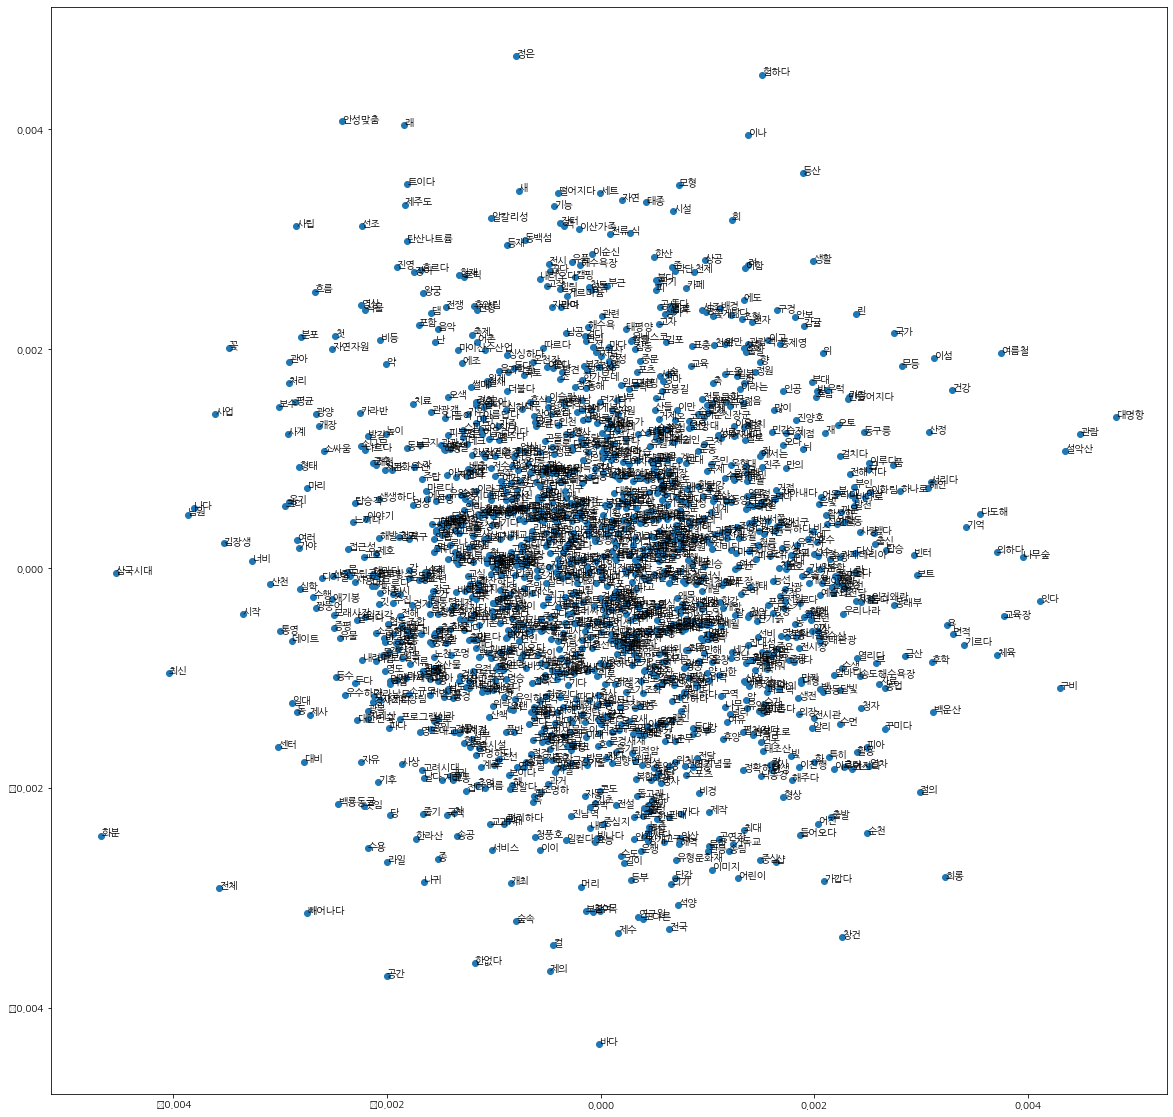

In [15]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
fm._rebuild()

plt.rc('font', family='NanumGothic')

import matplotlib.pyplot as plt

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

3. 단어 벡터의 평균 구하기

In [16]:
word2vec_model=model

def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab.keys():
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list 

In [17]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 618


<ipython-input-16-423daef1966c>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-16-423daef1966c>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


4. 추천 시스템 구현하기

In [18]:
# 각 벡터간 코사인 유사도

cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (618, 618)


In [19]:
# 코사인 유사도를 이용하여, 가장 소개가 비슷한 5개의 관광지를 찾아내는 함수 만들기

In [20]:
def recommendations(pos):
    books = df[['관광지명']]
    # 관광지명을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['관광지명']).drop_duplicates() 
    idx = indices[pos]

    # 입력된 관광지와 소개(info embedding)가 유사한 관광지 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 관광지 5곳의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    # 순차적으로 관광지명을 출력
    for i in book_indices:
        print(books.loc[i]['관광지명'])

In [21]:
# 확인 : 관광지명을 입력하면 이와 유사한 관광지들 추천

In [23]:
recommendations('한국가구박물관')

직탕
안동문화관광지
한국이슬람부산성원
동학농민혁명기념공원
아쿠아리움


In [24]:
recommendations('위봉사&위봉폭포&위봉산성')

대아수목원&대아호
한국가구박물관
데미샘자연휴양림
영도대교
창원단감테마공원


In [25]:
recommendations('클레이아크')

국립김해박물관
무주 덕유산 리조트
그림책미술관
운주사
성류굴 관광지


In [26]:
recommendations('성류굴 관광지')

클레이아크
국립김해박물관
무주 덕유산 리조트
섬진강 기차마을
운주사


In [27]:
recommendations('석정온천관광지')

화순온천
대광해수욕장
구문소 관광지
팔달대교 야경
진안고원치유의숲


In [28]:
recommendations('문수산성')

화순온천
염선재
소래포구
난지섬관광지
구문소 관광지
